In [ ]:
!pip install pyprind

In [ ]:
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
from torch.autograd import Variable
from tqdm import tqdm
import nltk

import random
from sklearn.metrics import classification_report

import pyprind
import matplotlib.pyplot as plt

%matplotlib inline  

In [ ]:
import pandas as pd
import nltk
import tensorflow as tf
import torch
import torch.nn as nn
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
from torchtext.legacy import data

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


#Pre-Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_csv = '/content/drive/MyDrive/MSDS/DL/A5/imdb_dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')
print(f'shape of dev data is {x_dev.shape}')

shape of train data is (27000,)
shape of test data is (12000,)
shape of dev data is (9000,)


In [ ]:
y_test

array(['positive', 'negative', 'negative', ..., 'negative', 'positive',
       'positive'], dtype=object)

#End Part

In [ ]:
def seq_length(data,label,seq_len):
  data_seq_len = []
  for i in range(len(data)):
    data_seq_len.append(" ".join(data[i].split()[:seq_len]))
  df = pd.DataFrame()
  df['reviews'] = data_seq_len
  df['senti'] = label

  df = df.sample(frac = 1).reset_index(drop=True)

  return df

In [ ]:
seq_len = 35
df_train = seq_length(x_train,y_train,seq_len)
df_dev = seq_length(x_dev,y_dev,seq_len)
df_test = seq_length(x_test,y_test,seq_len)

In [ ]:
df_train.to_csv("/content/drive/MyDrive/MSDS/DL/A5/data/train.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/MSDS/DL/A5/data/test.csv", index=False)
df_dev.to_csv("/content/drive/MyDrive/MSDS/DL/A5/data/dev.csv", index=False)

##Loading Data

In [ ]:
# sample tokenizer which you can use
def tokenizer(text):
    return [tok for tok in text.split()]

In [ ]:
# tokenizer = "spacy" uses spacy's tokenizer
TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenizer)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# loading train, test and validation data 
train_data, dev_data, test_data = data.TabularDataset.splits(
    path="/content/drive/MyDrive/MSDS/DL/A5/data/", train="train.csv", 
    validation="dev.csv", test="test.csv",format="csv", skip_header=True, 
    fields=[('reviews', TEXT), ('senti', LABEL)]
)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(dev_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 27000
Number of valid examples: 9000
Number of testing examples: 12000


In [ ]:
train_data

In [ ]:
TEXT.build_vocab(train_data, vectors="glove.6B.100d", max_size=40000, min_freq=1)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399392/400000 [00:17<00:00, 27057.15it/s]

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 40002
Unique tokens in LABEL vocabulary: 2


In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# keep in mind the sort_key option 
train_iterator, dev_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, dev_data, test_data), sort_key=lambda x: len(x.reviews),
    batch_size=BATCH_SIZE,
    device=device)

In [ ]:
for i in train_iterator:
  print(i)
  break


[torchtext.legacy.data.batch.Batch of size 32]
	[.reviews]:[torch.cuda.LongTensor of size 35x32 (GPU 0)]
	[.senti]:[torch.cuda.LongTensor of size 32 (GPU 0)]


## RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        
        #embedded = [sent len, batch size, emb dim]
        # print(x.shape)
        # print(embedded.shape)
        #pack sequence
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        hidden = self.dropout(hidden)
        
        out = self.fc(hidden)
        return out

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 500
OUTPUT_DIM = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_rnn = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            DROPOUT)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_rnn.embedding.weight.data = pretrained_embeddings.cuda()

class_weights = torch.tensor([1.0, 1.0]).cuda()

optimizer = optim.Adam(model_rnn.parameters(), lr=0.00003)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_rnn = model_rnn.to(device)
criterion = criterion.to(device)

torch.Size([40002, 100])


In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
    correct = (ind == y).float()
    acc = correct.sum()/float(len(correct))

    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        optimizer.zero_grad()
        # batch, batch_lengths = batch.reviews

        predictions = model(batch.reviews).squeeze(0)
#         print(predictions.shape, batch.Label.shape, model(batch.Text).shape)
        # print("idar")
        # print(predictions.shape)
        # print(batch.senti.reshape((len(batch.senti),1)).shape)

        loss = criterion(predictions, batch.senti)

        acc = binary_accuracy(predictions, batch.senti)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        bar.update()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:

            predictions = model(batch.reviews).squeeze(0)
            
            loss = criterion(predictions, batch.senti)
            
            acc = binary_accuracy(predictions, batch.senti)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            bar.update()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 5
train_rnn_loss = []
train_rnn_acc = []
dev_rnn_loss = []
dev_rnn_acc = []


for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model_rnn, train_iterator, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model_rnn, dev_iterator, criterion)
    
    train_rnn_loss.append(train_loss)
    train_rnn_acc.append(train_acc)

    dev_rnn_loss.append(dev_loss)
    dev_rnn_acc.append(dev_acc)


    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {dev_loss:.3f} | Val. Acc: {dev_acc*100:.2f}% |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 01 | Train Loss: 0.696 | Train Acc: 51.06% | Val. Loss: 0.689 | Val. Acc: 53.32% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 02 | Train Loss: 0.669 | Train Acc: 58.35% | Val. Loss: 0.640 | Val. Acc: 64.06% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 03 | Train Loss: 0.647 | Train Acc: 62.73% | Val. Loss: 0.617 | Val. Acc: 66.13% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


| Epoch: 04 | Train Loss: 0.639 | Train Acc: 63.67% | Val. Loss: 0.618 | Val. Acc: 66.27% |


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 05 | Train Loss: 0.635 | Train Acc: 64.39% | Val. Loss: 0.609 | Val. Acc: 66.94% |



Total time elapsed: 00:00:00


## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        # print("here1")
        #embedded = [sent len, batch size, emb dim]
        # print(x.shape)
        # print(embedded.shape)
        output, (hidden,cell) = self.rnn(embedded)
        # print("here2")
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # print(hidden)
        # print(hidden[0].shape)
        hidden = self.dropout(hidden)
        # print("here3")
        out = self.fc(hidden)
        # print("here4")
        return out

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 500
OUTPUT_DIM = 2
DROPOUT = 0.5

model_lstm = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_lstm.embedding.weight.data = pretrained_embeddings

class_weights = torch.tensor([1.0, 1.0])

optimizer = optim.Adam(model_lstm.parameters(), lr=0.00003)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_lstm = model_lstm.to(device)
criterion = criterion.to(device)

torch.Size([40002, 100])


In [ ]:
N_EPOCHS = 5
train_lstm_loss = []
train_lstm_acc = []
dev_lstm_loss = []
dev_lstm_acc = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model_lstm, train_iterator, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model_lstm, dev_iterator, criterion)
    
    train_lstm_loss.append(train_loss)
    train_lstm_acc.append(train_acc)

    dev_lstm_loss.append(dev_loss)
    dev_lstm_acc.append(dev_acc)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {dev_loss:.3f} | Val. Acc: {dev_acc*100:.2f}% |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 01 | Train Loss: 0.691 | Train Acc: 52.55% | Val. Loss: 0.687 | Val. Acc: 56.56% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 02 | Train Loss: 0.656 | Train Acc: 61.22% | Val. Loss: 0.622 | Val. Acc: 64.79% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 03 | Train Loss: 0.634 | Train Acc: 64.09% | Val. Loss: 0.613 | Val. Acc: 66.71% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 04 | Train Loss: 0.626 | Train Acc: 65.03% | Val. Loss: 0.600 | Val. Acc: 67.38% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 05 | Train Loss: 0.616 | Train Acc: 65.61% | Val. Loss: 0.595 | Val. Acc: 68.09% |



Total time elapsed: 00:00:00


##GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        # print("here1")
        #embedded = [sent len, batch size, emb dim]
        # print(x.shape)
        # print(embedded.shape)
        output, hidden = self.rnn(embedded)
        # print("here2")
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # print(hidden)
        # print(hidden[0].shape)
        hidden = self.dropout(hidden)
        # print("here3")
        out = self.fc(hidden)
        # print("here4")
        return out

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 500
OUTPUT_DIM = 2
DROPOUT = 0.4

model_gru = GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_gru.embedding.weight.data = pretrained_embeddings

class_weights = torch.tensor([1.0, 1.0])

optimizer = optim.Adam(model_gru.parameters(), lr=0.00003)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_gru = model_gru.to(device)
criterion = criterion.to(device)

torch.Size([40002, 100])


In [ ]:
N_EPOCHS = 5
train_gru_loss = []
train_gru_acc = []
dev_gru_loss = []
dev_gru_acc = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model_gru, train_iterator, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model_gru, dev_iterator, criterion)
    
    train_gru_loss.append(train_loss)
    train_gru_acc.append(train_acc)

    dev_gru_loss.append(dev_loss)
    dev_gru_acc.append(dev_acc)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {dev_loss:.3f} | Val. Acc: {dev_acc*100:.2f}% |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

| Epoch: 01 | Train Loss: 0.690 | Train Acc: 53.25% | Val. Loss: 0.684 | Val. Acc: 56.72% |



0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 02 | Train Loss: 0.651 | Train Acc: 61.65% | Val. Loss: 0.615 | Val. Acc: 65.91% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 03 | Train Loss: 0.624 | Train Acc: 65.14% | Val. Loss: 0.603 | Val. Acc: 67.03% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 04 | Train Loss: 0.613 | Train Acc: 66.09% | Val. Loss: 0.596 | Val. Acc: 67.71% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 05 | Train Loss: 0.606 | Train Acc: 67.02% | Val. Loss: 0.590 | Val. Acc: 68.35% |



Total time elapsed: 00:00:00


##Plots

In [ ]:
epochs = list(range(1,6))

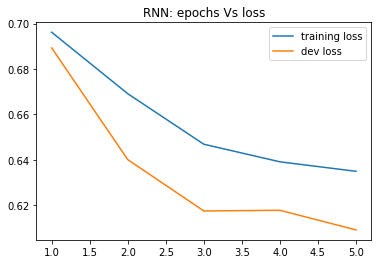

In [ ]:
plt.plot(epochs, train_rnn_loss, label='training loss')
plt.plot(epochs, dev_rnn_loss, label='dev loss')
plt.title("RNN: epochs Vs loss")
plt.legend()
plt.show()

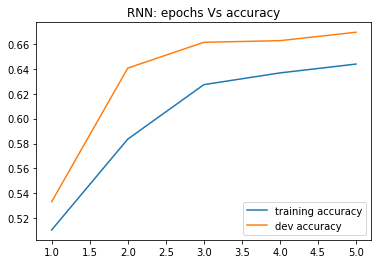

In [ ]:
plt.plot(epochs, train_rnn_acc, label='training accuracy')
plt.plot(epochs, dev_rnn_acc, label='dev accuracy')
plt.title("RNN: epochs Vs accuracy")
plt.legend()
plt.show()

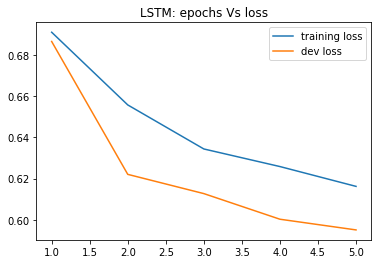

In [ ]:
plt.plot(epochs, train_lstm_loss, label='training loss')
plt.plot(epochs, dev_lstm_loss, label='dev loss')
plt.title("LSTM: epochs Vs loss")
plt.legend()
plt.show()

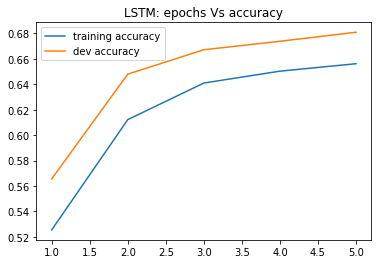

In [ ]:
plt.plot(epochs, train_lstm_acc, label='training accuracy')
plt.plot(epochs, dev_lstm_acc, label='dev accuracy')
plt.title("LSTM: epochs Vs accuracy")
plt.legend()
plt.show()

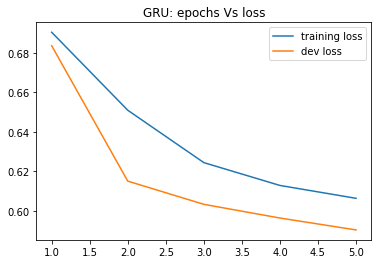

In [ ]:
plt.plot(epochs, train_gru_loss, label='training loss')
plt.plot(epochs, dev_gru_loss, label='dev loss')
plt.title("GRU: epochs Vs loss")
plt.legend()
plt.show()

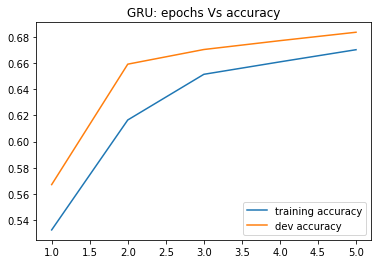

In [ ]:
plt.plot(epochs, train_gru_acc, label='training accuracy')
plt.plot(epochs, dev_gru_acc, label='dev accuracy')
plt.title("GRU: epochs Vs accuracy")
plt.legend()
plt.show()

##Evaluation

In [ ]:
def predict_sentiment(model,sentence):
    tokenized = [tok for tok in sentence.split()]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    tensor = tensor.unsqueeze(1)
#     print(tensor.shape)
    prediction = model(tensor)
#     print(prediction)
    preds, ind= torch.max(F.softmax(prediction.squeeze(0), dim=-1), 1)
#     print(preds)
    return preds, ind

In [ ]:
# calculating classification report
test_data = pd.read_csv("/content/drive/MyDrive/MSDS/DL/A5/data/test.csv")

In [ ]:
pre = [predict_sentiment(model_rnn,k)[1].item() for k in test_data.reviews]
actual = test_data.senti = [1 if label =='positive' else 0 for label in y_test]
print(classification_report(actual, pre))

              precision    recall  f1-score   support

           0       0.49      0.41      0.45      6000
           1       0.49      0.58      0.53      6000

    accuracy                           0.49     12000
   macro avg       0.49      0.49      0.49     12000
weighted avg       0.49      0.49      0.49     12000



In [ ]:
pre = [predict_sentiment(model_lstm,k)[1].item() for k in test_data.reviews]
print(classification_report(test_data.senti, pre))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49      6000
           1       0.50      0.51      0.50      6000

    accuracy                           0.50     12000
   macro avg       0.50      0.50      0.50     12000
weighted avg       0.50      0.50      0.50     12000



In [ ]:
pre = [predict_sentiment(model_gru,k)[1].item() for k in test_data.reviews]
print(classification_report(test_data.senti, pre))

              precision    recall  f1-score   support

           0       0.49      0.40      0.44      6000
           1       0.49      0.59      0.54      6000

    accuracy                           0.49     12000
   macro avg       0.49      0.49      0.49     12000
weighted avg       0.49      0.49      0.49     12000



<function matplotlib.pyplot.show>

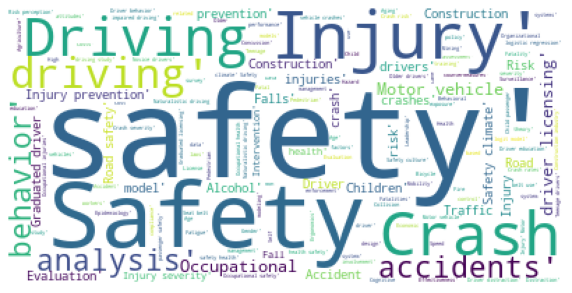

In [ ]:
stopwords = set(STOPWORDS)
hg = WordCloud(background_color='white',max_words=200,stopwords=stopwords)
#generate wordcloud
hg.generate(str(keywords))
#display
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(10)




plt.imshow(hg)
plt.axis('off')
plt.show


In [ ]:
affiliated_authors  = accident['Authors'].to_string()

**Occurence of Authors**

<function matplotlib.pyplot.show>

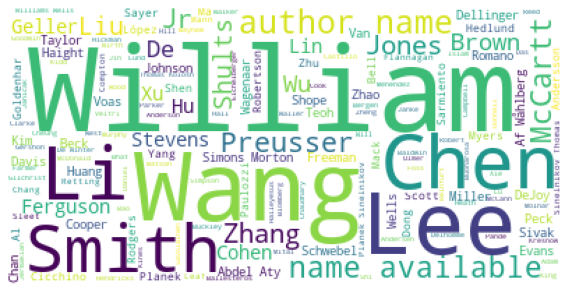

In [ ]:
hg.generate(str(affiliated_authors))
#display
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(10)




plt.imshow(hg)
plt.axis('off')
plt.show

**Occurence of Keywords in Scatter Graph**